### End to end train both networks

In [1]:
from keras.layers import Input, Dense, Activation, Lambda, Dropout, Concatenate, Reshape
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard
from keras import optimizers
from keras import backend as K

import tensorflow as tf

from keras.regularizers import l2


/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
### Hyperparameters

experiment_id = 0

learning_rate = 0.0001

epochs = [200, 20000, 10000, 4000]
batch_sizes = [1024, 1024, 128, 1024]

lambda_1 = 0.1       ### TODO
lambda_2 = 0.005     ### TODO

#################

epoch = epochs[experiment_id]
batch_size = batch_sizes[experiment_id]

### Define compresion network

In [3]:
input_data = Input(batch_shape=(batch_size,120), name='input')

encoded = Dense(60, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(input_data)
encoded = Dense(30, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(encoded)
encoded = Dense(10, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(encoded)

low_dim = Dense(1, activation='linear', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001), name='lowdim')(encoded)

decoded = Dense(10, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(low_dim)
decoded = Dense(30, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(decoded)
decoded = Dense(60, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(decoded)
decoded = Dense(120, activation='linear', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001), name='reconstructed')(decoded)



- Define similarity metrics

In [4]:
def cos_sim(a_b):
    '''
    a: batch x 120
    b: batch x 120 
    
    output: batch x 1
    '''
    a, b = a_b
    
    norm_a = K.sqrt(K.sum(a ** 2, axis=-1))
    norm_b = K.sqrt(K.sum(b ** 2, axis=-1))
    
    out = K.sum(a * b, axis=-1) / (norm_a * norm_b)
    out = K.reshape(out, [batch_size, 1])
    
    return out

def relative_euc_dist(a_b):
    '''
    a: batch x 120
    b: batch x 120 
    
    output: batch x 1
    '''
    a,b = a_b
    
    norm_diff = K.sqrt(K.sum((a - b)**2, axis=-1))
    norm_a = K.sqrt(K.sum(a ** 2, axis=-1))
    
    out = norm_diff / norm_a
    out = K.reshape(out, [batch_size, 1])

    return out

In [5]:
layer_cossim = Lambda(cos_sim,
                      name='cos_sim')([input_data, decoded])

In [6]:
layer_cossim

<tf.Tensor 'cos_sim/Reshape:0' shape=(1024, 1) dtype=float32>

In [7]:
layer_relativeEuc = Lambda(relative_euc_dist, 
                           name='relative_euc_dist')([input_data, decoded])

In [8]:
layer_relativeEuc

<tf.Tensor 'relative_euc_dist/Reshape:0' shape=(1024, 1) dtype=float32>

- No need to reshape low_dim

In [9]:
low_dim

<tf.Tensor 'lowdim/BiasAdd:0' shape=(1024, 1) dtype=float32>

- Obtain "z"

In [10]:
def funct_concat(tensors):
    return K.concatenate(tensors)

layer_concat = Lambda(funct_concat, name="z")([low_dim, layer_cossim, layer_relativeEuc])

In [11]:
layer_concat

<tf.Tensor 'z/concat:0' shape=(1024, 3) dtype=float32>

### Define estimation network

In [12]:
input_est = layer_concat #Input(shape=(3,))(layer_concat)

est_layer = Dense(10, activation='tanh', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(input_est)   ####(input_est)
est_layer = Dropout(0.5)(est_layer)
est_output = Dense(4, activation='softmax', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))(est_layer)


### Build full network

In [13]:
full_network = Model(input=input_data, outputs=est_output)

/home/cya/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


In [14]:
full_network.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (1024, 120)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (1024, 60)           7260        input[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (1024, 30)           1830        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (1024, 10)           310         dense_2[0][0]                    
__________________________________________________________________________________________________
lowdim (De

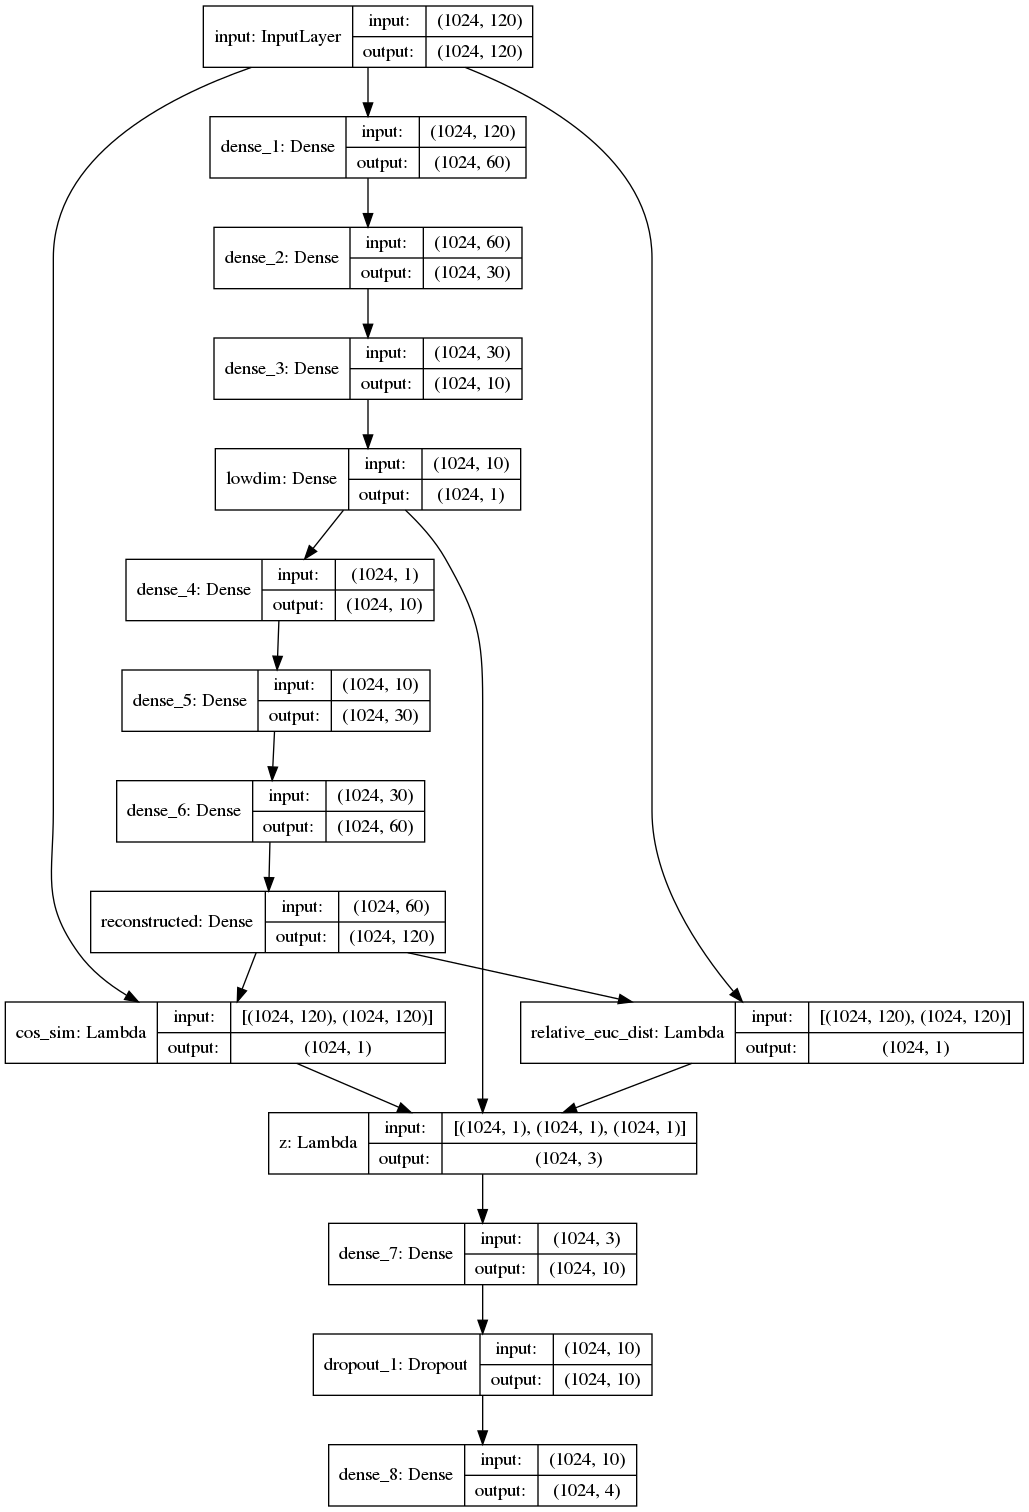

In [15]:
### model visualization
from keras.utils import plot_model


model = full_network

plot_model(model, to_file='model.png', show_layer_names=True, show_shapes=True)

from IPython.display import Image
Image(filename='model.png') 

### Load already saved dataset

In [16]:
import numpy as np

In [17]:
with np.load('kdd99_train_test.npz') as data:
    x_train = data['x_train']     
    x_test = data['x_test']
    x_all = np.concatenate([x_train, x_test], axis=0)

In [18]:
x_all.shape

(494021, 120)

- Get only the normal data

In [19]:
normal_data = x_all[np.where(x_all[:,-1] == 1)]   ##last column is the normal column

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
x_train, x_test = train_test_split(normal_data, test_size=0.5, random_state=42)

In [22]:
x_train.shape

(48639, 120)

In [23]:
x_test.shape

(48639, 120)

- Assign arbitrary output (assuming first column is normal)

In [24]:
y_train = np.zeros((len(x_train),4))

y_train[:,0] = 1

In [25]:
y_train.shape

(48639, 4)

### Try training

In [26]:
adam = optimizers.adam(lr=learning_rate, clipnorm=1., clipvalue=0.5)  # (lr=0.0001)

def l2_loss(yTrue, yPred):
    return K.sqrt((yTrue - yPred)**2) 

In [27]:
full_network.compile(optimizer=adam, loss=l2_loss)

In [28]:
### Tensorboard
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d_%H:%M")
print(timestamp, "")

tensorboard = TensorBoard(log_dir='./.logs/compNet+estNet_kdd99/{}'.format(timestamp), 
                            histogram_freq=0, 
                            write_graph=True, 
                            write_grads=True, 
                            write_images=True, 
                            embeddings_freq=0, 
                            embeddings_layer_names=None, 
                            embeddings_metadata=None)

2018-05-15_18:34 
Instructions for updating:
Use the retry module or similar alternatives.


- training with fit_generator

In [29]:
def batchGenerator():
    '''
    return: number of batch_size examples in each run
    '''
    while True:
        choices = np.random.choice(len(x_train), size=batch_size, replace=False)
        batch_x_train = x_train[choices]
        batch_y_train = y_train[choices]
        
        yield (batch_x_train, batch_y_train)

In [30]:
steps_per_epoch = int(np.ceil(x_train.shape[0] / batch_size))

In [31]:
steps_per_epoch

48

In [32]:
"""
48639 (len of train) not divisible by 1024 (batch size)
48639 ÷ 1024 = 47,499023437

therefore, randomly sample 1024 data (batch size), 48 times (steps_per_epoch)

"""

history = full_network.fit_generator(batchGenerator(),
                           epochs = epoch,
                           steps_per_epoch = steps_per_epoch,
                           callbacks = [tensorboard],
                           verbose = 1)

Epoch 1/200
48/48 [==============================] - 1s 20ms/step - loss: 0.3679
Epoch 2/200
48/48 [==============================] - 0s 9ms/step - loss: 0.3522
Epoch 3/200
48/48 [==============================] - 0s 9ms/step - loss: 0.3313
Epoch 4/200
48/48 [==============================] - 0s 9ms/step - loss: 0.3080
Epoch 5/200
48/48 [==============================] - 0s 9ms/step - loss: 0.2861
Epoch 6/200
48/48 [==============================] - 0s 10ms/step - loss: 0.2683
Epoch 7/200
48/48 [==============================] - 0s 10ms/step - loss: 0.2525
Epoch 8/200
48/48 [==============================] - 0s 9ms/step - loss: 0.2365
Epoch 9/200
48/48 [==============================] - 0s 10ms/step - loss: 0.2239
Epoch 10/200
48/48 [==============================] - 0s 9ms/step - loss: 0.2111
Epoch 11/200
48/48 [==============================] - 0s 9ms/step - loss: 0.1987
Epoch 12/200
48/48 [==============================] - 0s 9ms/step - loss: 0.1872
Epoch 13/200
48/48 [=============

48/48 [==============================] - 0s 9ms/step - loss: 0.0118
Epoch 102/200
48/48 [==============================] - 0s 9ms/step - loss: 0.0119
Epoch 103/200
48/48 [==============================] - 0s 9ms/step - loss: 0.0114
Epoch 104/200
48/48 [==============================] - 0s 9ms/step - loss: 0.0114
Epoch 105/200
48/48 [==============================] - 0s 9ms/step - loss: 0.0111
Epoch 106/200
48/48 [==============================] - 0s 9ms/step - loss: 0.0108
Epoch 107/200
48/48 [==============================] - 0s 9ms/step - loss: 0.0105
Epoch 108/200
48/48 [==============================] - 0s 9ms/step - loss: 0.0106
Epoch 109/200
48/48 [==============================] - 0s 9ms/step - loss: 0.0104
Epoch 110/200
48/48 [==============================] - 0s 9ms/step - loss: 0.0101
Epoch 111/200
48/48 [==============================] - 0s 9ms/step - loss: 0.0099
Epoch 112/200
48/48 [==============================] - 0s 9ms/step - loss: 0.0100
Epoch 113/200
48/48 [=========

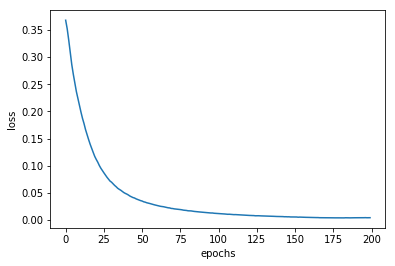

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_historyData(data, xlabel="epochs", ylabel="loss"):
    plt.plot(data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
plot_historyData(history.history["loss"])